Data Mining Project 2019-Sentiment Analysis

Importing the suitable libraries...

In [25]:
import csv
import numpy as np
import pandas as pd
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import  WordNetLemmatizer
from nltk.stem import PorterStemmer,RegexpStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from gensim.models import Word2Vec
from wordcloud import WordCloud





Loading ,reading the dataset and creating a list of dictionaries(1 for each available lexicon).

In [3]:
messages = pd.read_csv('train2017.tsv', sep='\t',quoting=csv.QUOTE_NONE, names=["id1","id2","label", "tweet"])
print(len(messages))
test1 = pd.read_csv('test2017.tsv', sep='\t',quoting=csv.QUOTE_NONE, names=["id1","id2","label", "tweet"])
test2 = pd.read_csv('SemEval2017_task4_subtaskA_test_english_gold.txt', sep='\t',quoting=csv.QUOTE_NONE, names=["id","label"])
tweets,labels = messages["tweet"],messages["label"]
test_labels = test2["label"]
test_tweets=test1["tweet"]
converted_labels=[]
for l in labels:
    if(l=="positive"):
        converted_labels.append(0)
    elif(l=="negative"):
        converted_labels.append(1)
    else:
        converted_labels.append(2)

test_converted_labels=[]
for l in test_labels:
    if(l=="positive"):
        test_converted_labels.append(0)
    elif(l=="negative"):
        test_converted_labels.append(1)
    else:
        test_converted_labels.append(2)
        
lex_names = ['../lexica/affin/affin.txt','../lexica/emotweet/valence_tweet.txt','../lexica/generic/generic.txt','../lexica/nrc/val.txt','../lexica/nrctag/val.txt']
list_of_dicts = []

for name in lex_names:
    sentiment_dict = {}
    with open(name) as fp:  
        line = fp.readline()
        splitted_line = line.split()
        if(len(splitted_line) == 2):
            sentiment_dict[str(splitted_line[0])] = float(splitted_line[1])
        while line:
            line = fp.readline()
            splitted_line = line.split()
            if(len(splitted_line) == 2):
                sentiment_dict[str(splitted_line[0])] = float(splitted_line[1])
        list_of_dicts.append(sentiment_dict)

28061


Removing links,lower,tokenization(with RegexpTokenizer who removes punktuation also),Stopword removal,number removal,stemming(lemmatizing).



Tried both WordNetlemmatizer and PorterStemmer and WordNetLemmatizer seems better.

It was crucial for us to clean the text with the best but also the quicker way.So we managed to make this process in 3 minutes for the entire set of tweets and make it really clean if we consider the results we take after all the process.


In [4]:
converted_tweets=[]
count=0
for t in tweets:
    t= ' '.join(item for item in t.split() if not (item.startswith('http')))
    t= ' '.join(item for item in t.split() if not (item.startswith('@')))
    t= ' '.join(item for item in t.split() if not (item.startswith('#')))
    t=t.lower()
    tknzr = RegexpTokenizer(r'\w+')
    tokenized_tweet = tknzr.tokenize(t)
    filtered_tweet = [w for w in tokenized_tweet if not w in stopwords.words('english')]
    filtered_tweet = [w for w in filtered_tweet if w.isalpha() ]
    #stemmer=PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweet=[lemmatizer.lemmatize(token) for token in filtered_tweet]
    #stemmed_tweet=[stemmer.stem(token) for token in filtered_tweet]
    #if(count<20):
        #print(filtered_tweet)
        #print(stemmed_tweet)
        #print(lemmatized_tweet)
    converted_tweets.append(lemmatized_tweet)
    count=count+1;
#print(converted_tweets)


Construct a wordcloud of the most common words in the whole text and saving it in wordcloud.png

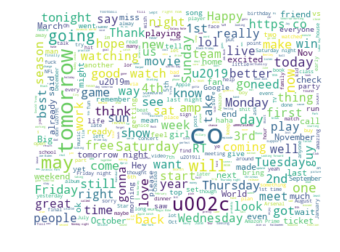

In [28]:
text = " ".join(review for review in messages.tweet)
wordcloud = WordCloud(width=400,height=300,max_font_size=40, max_words=1000, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud.png")

The same process for test2017.tsv

In [5]:
test_converted_tweets=[]
count=0
for t in test_tweets:
    t= ' '.join(item for item in t.split() if not (item.startswith('http')))
    t= ' '.join(item for item in t.split() if not (item.startswith('@')))
    t= ' '.join(item for item in t.split() if not (item.startswith('#')))
    t=t.lower()
    tknzr = RegexpTokenizer(r'\w+')
    tokenized_tweet = tknzr.tokenize(t)
    filtered_tweet = [w for w in tokenized_tweet if not w in stopwords.words('english')]
    filtered_tweet = [w for w in filtered_tweet if w.isalpha() ]
    #stemmer=PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweet=[lemmatizer.lemmatize(token) for token in filtered_tweet]
    #stemmed_tweet=[stemmer.stem(token) for token in filtered_tweet]
    #if(count<20):
        #print(filtered_tweet)
        #print(stemmed_tweet)
        #print(lemmatized_tweet)
    test_converted_tweets.append(lemmatized_tweet)
    count=count+1;
#print(converted_tweets)

BOW,TF-IDF Vectorization

In [36]:
vectorizer = TfidfVectorizer(max_df=1.0, min_df=1,stop_words='english')
#vectorizer = CountVectorizer(max_df=1.0, min_df=1,stop_words='english')
corpus = []
for t in converted_tweets:
    string_tweet = ' '
    for w in t:
        string_tweet = string_tweet + w + ' '
    corpus.append(string_tweet)
vectorized_tweets= vectorizer.fit_transform(corpus)


Dimensionality reduction using SVD(we tried many different values for n_components)

In [37]:
svd = TruncatedSVD(n_components=200, n_iter=10)
svd_tweets = svd.fit_transform(vectorized_tweets)

The same process for test2017.tsv

In [38]:
vectorizer = TfidfVectorizer(max_df=1.0, min_df=1,stop_words='english')
#vectorizer = CountVectorizer(max_df=1.0, min_df=1,stop_words='english')
corpus = []
for t in test_converted_tweets:
    string_tweet = ' '
    for w in t:
        string_tweet = string_tweet + w + ' '
    corpus.append(string_tweet)
test_vectorized_tweets= vectorizer.fit_transform(corpus)

svd = TruncatedSVD(n_components=200, n_iter=10)
test_svd_tweets = svd.fit_transform(test_vectorized_tweets)

Our Word2vec vectorization

In [10]:
model_w2v = Word2Vec(converted_tweets, size=200, window=5, min_count=1, workers=4)
model_w2v.train(converted_tweets, total_examples= len(converted_tweets), epochs=2)
model=model_w2v
print(model)
w2v_tweets = []
for t in converted_tweets:
    tweet_embedding =  np.full(200,0)
    for word in t:
        for i in range (0,len(model.wv[word])):
            tweet_embedding[i] += model.wv[word][i]
    for i in range(0,len(model.wv[word])):
        if np.isnan((float(len(t)))==False):
            tweet_embedding[i] = tweet_embedding[i]/float(len(t))
    w2v_tweets.append(tweet_embedding)

Word2Vec(vocab=25398, size=200, alpha=0.025)


The same for test2017.tsv

In [11]:
test_model_w2v = Word2Vec(test_converted_tweets, size=200, window=5, min_count=1, workers=4)
test_model_w2v.train(test_converted_tweets, total_examples= len(test_converted_tweets), epochs=2)
model=test_model_w2v
print(model)
test_w2v_tweets = []
for t in test_converted_tweets:
    tweet_embedding =  np.full(200,0)
    for word in t:
        for i in range (0,len(model.wv[word])):
            tweet_embedding[i] += model.wv[word][i]
    for i in range(0,len(model.wv[word])):
        if np.isnan((float(len(t)))==False):
            tweet_embedding[i] = tweet_embedding[i]/float(len(t))
    test_w2v_tweets.append(tweet_embedding)

Word2Vec(vocab=15235, size=200, alpha=0.025)


Creating sentiment vectors(based on our five given lexicon so we have 5 spots) and concatenating with each of our vectorized tweets.

In [39]:
vectors = []

for t in converted_tweets:
    tweet_array = np.zeros(len(list_of_dicts))
    for i in range(0,len(list_of_dicts)):
        count = 0
        for word in t:
            value = list_of_dicts[i].get(word)
            if(value!=None):
                count += 1
                tweet_array[i] += value
        #compute the mean valance
        if(count!=0):
            tweet_array[i] = tweet_array[i]/float(count)
    vectors.append(tweet_array)
lexicon_vectors=np.array(vectors)

vectors = []

result_vecs = []
for i in range(0,svd_tweets.shape[0]):
    vec = []
    for v in w2v_tweets[i]:
        vec.append(v)
    for v in lexicon_vectors[i]:
        vec.append(v)
    result_vecs.append(np.array(vec))
        
final_tweets=np.array(result_vecs)


result_vecs = []
for i in range(0,svd_tweets.shape[0]):
    vec = []
    for v in svd_tweets[i]:
        vec.append(v)
    for v in lexicon_vectors[i]:
        vec.append(v)
    result_vecs.append(np.array(vec))
        
svdfinal_tweets=np.array(result_vecs)


The same for test2017.tsv

In [40]:
for t in test_converted_tweets:
    tweet_array = np.zeros(len(list_of_dicts))
    for i in range(0,len(list_of_dicts)):
        count = 0
        for word in t:
            value = list_of_dicts[i].get(word)
            if(value!=None):
                count += 1
                tweet_array[i] += value
        #compute the mean valance
        if(count!=0):
            tweet_array[i] = tweet_array[i]/float(count)
    vectors.append(tweet_array)
test_lexicon_vectors=np.array(vectors)

result_vecs = []
for i in range(0,test_svd_tweets.shape[0]):
    vec = []
    for v in test_w2v_tweets[i]:
        vec.append(v)
    for v in test_lexicon_vectors[i]:
        vec.append(v)
    result_vecs.append(np.array(vec))
        
test_final_tweets=np.array(result_vecs)

result_vecs = []
for i in range(0,test_svd_tweets.shape[0]):
    vec = []
    for v in test_svd_tweets[i]:
        vec.append(v)
    for v in test_lexicon_vectors[i]:
        vec.append(v)
    result_vecs.append(np.array(vec))
        
testsvdfinal_tweets=np.array(result_vecs)

KNN Classifier(we tried many different values of different n_neighbors to succeed the best result)


SVM Classifier
(the worst kernel is poly,the best is linear)

We tested our classifiers with test2017.tsv ,training them with train2017.tsv.Although initially we used the following train_test_split method:

Using train_test_split to split the dataset into train and test(shuffle by default true,so we have random parts of the dataset).We are spliting the dataset 70% for training and 30% for testing.

Evaluating the whole method using accuracy,f1score,confusion matrix and classification report ,in order to have the best possible conclusion!

We have also inserted a visualization for confusion_matrix using matplotlib pyplot.

We do the same process(and visualizations) both for Word2vec and for TF-IDF to spot the differences

0.5524259198957994
0.5552463925847396
[[1357   93  925]
 [ 518 1946 1508]
 [1423 1031 3483]]


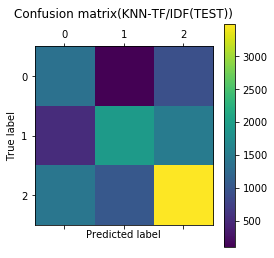

             precision    recall  f1-score   support

   Positive       0.41      0.57      0.48      2375
   Negative       0.63      0.49      0.55      3972
    Neutral       0.59      0.59      0.59      5937

avg / total       0.57      0.55      0.56     12284



In [41]:
classifier = KNeighborsClassifier(n_neighbors=15,metric='cosine')
classifier.fit(svdfinal_tweets, converted_labels)
predictions=classifier.predict(testsvdfinal_tweets)
print(metrics.accuracy_score(test_converted_labels, predictions))
print(f1_score(test_converted_labels, predictions,average='weighted'))
conf_matrix = confusion_matrix(test_converted_labels, predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(KNN-TF/IDF(TEST))\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(test_converted_labels, predictions, target_names=target_names))

0.534028003907522
0.5357263917374706
[[1156   89 1130]
 [ 460 1889 1623]
 [1314 1108 3515]]


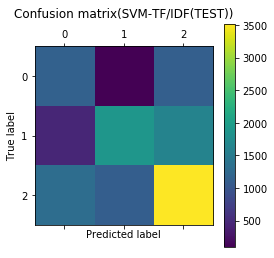

             precision    recall  f1-score   support

   Positive       0.39      0.49      0.44      2375
   Negative       0.61      0.48      0.54      3972
    Neutral       0.56      0.59      0.58      5937

avg / total       0.55      0.53      0.54     12284



In [42]:
classifier = SVC(kernel='linear')
classifier.fit(svdfinal_tweets, converted_labels)
predictions=classifier.predict(testsvdfinal_tweets)
print(metrics.accuracy_score(test_converted_labels, predictions))
print(f1_score(test_converted_labels, predictions,average='weighted'))
conf_matrix = confusion_matrix(test_converted_labels, predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(SVM-TF/IDF(TEST))\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(test_converted_labels, predictions, target_names=target_names))

0.5327254965809183
0.5388956540101948
[[1434  122  819]
 [ 721 1998 1253]
 [1734 1091 3112]]


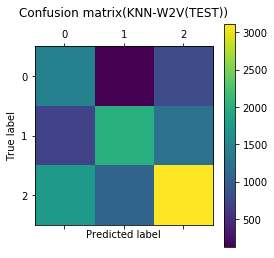

             precision    recall  f1-score   support

   Positive       0.37      0.60      0.46      2375
   Negative       0.62      0.50      0.56      3972
    Neutral       0.60      0.52      0.56      5937

avg / total       0.56      0.53      0.54     12284



In [15]:
classifier = KNeighborsClassifier(n_neighbors=15,metric='cosine')
classifier.fit(final_tweets, converted_labels)
predictions=classifier.predict(test_final_tweets)
print(metrics.accuracy_score(test_converted_labels, predictions))
print(f1_score(test_converted_labels, predictions,average='weighted'))
conf_matrix = confusion_matrix(test_converted_labels, predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(KNN-W2V(TEST))\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(test_converted_labels, predictions, target_names=target_names))

0.5761966786063172
0.5547141244501672
[[1061   36 1278]
 [ 144 1285 2543]
 [ 593  612 4732]]


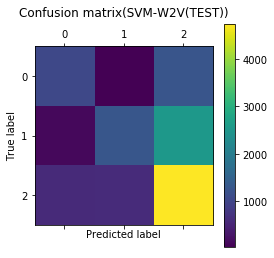

             precision    recall  f1-score   support

   Positive       0.59      0.45      0.51      2375
   Negative       0.66      0.32      0.44      3972
    Neutral       0.55      0.80      0.65      5937

avg / total       0.60      0.58      0.55     12284



In [17]:
classifier = SVC(kernel='linear')
classifier.fit(final_tweets, converted_labels)
predictions=classifier.predict(test_final_tweets)
print(metrics.accuracy_score(test_converted_labels, predictions))
print(f1_score(test_converted_labels, predictions,average='weighted'))
conf_matrix = confusion_matrix(test_converted_labels, predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(SVM-W2V(TEST))\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(test_converted_labels, predictions, target_names=target_names))

From now on we see the results of the same methods,used only in our train2017.tsv(tain_test_split).As we were expecting the results are further better due to the fact that the model is trained in similar tweets to those it is tested!

0.6358237320346835
0.6314007696598396
[[2391  114  985]
 [ 248  534  549]
 [ 934  236 2428]]


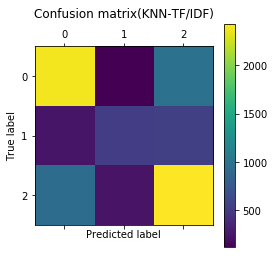

             precision    recall  f1-score   support

   Positive       0.67      0.69      0.68      3490
   Negative       0.60      0.40      0.48      1331
    Neutral       0.61      0.67      0.64      3598

avg / total       0.63      0.64      0.63      8419



In [43]:
classifier = KNeighborsClassifier(n_neighbors=15,metric='cosine')
X_train, X_test, y_train, y_test = train_test_split(svdfinal_tweets, converted_labels, test_size=0.3)
classifier.fit(X_train,y_train)
predictions=classifier.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))
print(f1_score(y_test, predictions,average='weighted'))
conf_matrix = confusion_matrix(y_test,predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(KNN-TF/IDF)\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(y_test, predictions, target_names=target_names))

0.6549471433661955
0.6468982718758962
[[2136   87 1207]
 [ 163  470  674]
 [ 597  177 2908]]


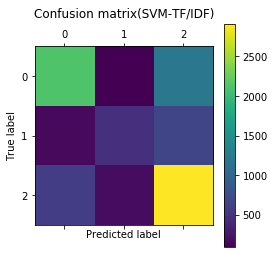

             precision    recall  f1-score   support

   Positive       0.74      0.62      0.68      3430
   Negative       0.64      0.36      0.46      1307
    Neutral       0.61      0.79      0.69      3682

avg / total       0.67      0.65      0.65      8419



In [41]:
classifier = SVC(kernel='linear')
X_train, X_test, y_train, y_test = train_test_split(svdfinal_tweets, converted_labels, test_size=0.3)
classifier.fit(X_train,y_train)
predictions=classifier.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))
print(f1_score(y_test, predictions,average='weighted'))
conf_matrix = confusion_matrix(y_test,predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(SVM-TF/IDF)\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(y_test, predictions, target_names=target_names))

0.5790473928019955
0.5740542879754961
[[2291  132 1046]
 [ 316  462  535]
 [1210  305 2122]]


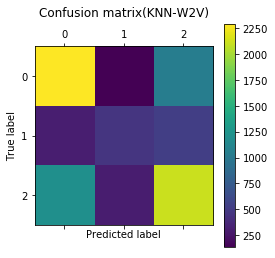

             precision    recall  f1-score   support

   Positive       0.60      0.66      0.63      3469
   Negative       0.51      0.35      0.42      1313
    Neutral       0.57      0.58      0.58      3637

avg / total       0.58      0.58      0.57      8419



In [38]:
classifier = KNeighborsClassifier(n_neighbors=15,metric='cosine')
X_train, X_test, y_train, y_test = train_test_split(final_tweets, converted_labels, test_size=0.3)
classifier.fit(X_train,y_train)
predictions=classifier.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))
print(f1_score(y_test, predictions,average='weighted'))
conf_matrix = confusion_matrix(y_test,predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(KNN-W2V)\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(y_test, predictions, target_names=target_names))


0.6190758997505642
0.6107029304726489
[[2034   66 1332]
 [ 167  433  714]
 [ 745  183 2745]]


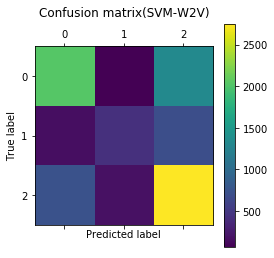

             precision    recall  f1-score   support

   Positive       0.69      0.59      0.64      3432
   Negative       0.63      0.33      0.43      1314
    Neutral       0.57      0.75      0.65      3673

avg / total       0.63      0.62      0.61      8419



In [42]:
classifier = SVC(kernel='linear')
X_train, X_test, y_train, y_test = train_test_split(final_tweets, converted_labels, test_size=0.3)
classifier.fit(X_train,y_train)
predictions=classifier.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))
print(f1_score(y_test, predictions,average='weighted'))
conf_matrix = confusion_matrix(y_test,predictions)
print(conf_matrix)
plt.matshow(conf_matrix)
plt.title('Confusion matrix(SVM-W2V)\n')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(y_test, predictions, target_names=target_names))



!CONCLUSION!


Considering our tests with the different types of vectorizers and classifiers we reached in the concurrent conclusion:

Word2Vec is not better than the other vectorizers (also it needs much more time for training).May if we have used pre-trained embeddings the result would be better.It results about 3-5% less than TF-IDF,which is better than BoW(they need the same little time).Also,Word2vec predicts 1% better than BoW when we use both test2017.tsv and train2017.tsv and 2-3% worse when we use only train2017.tsv data and splitting them!

Using only the train data and splitting them ,KNN is slightly worse than SVM ,thus it is really quicker!(KNN predicts 2-4% less than SVM).
In contrast,using train and test data KNN predicts 2% better than SVM with TF-IDF,and only 1% worse than SVM with Word2vec and BoW.

Finally,the best methods seem to be SVM and TF-IDF!(but the differences are tiny)

Below you see the whole results:

In [49]:
print("Results(training with train2017.tsv and testing with test2017.tsv)\n")
resultstest=pd.read_csv('results_test.csv',names=["Classifiers","TF-IDF","Bag of Words","Word2vec"])
print(resultstest)
print("\n")
print("Results(training and testing with train2017.tsv using train_test_split)\n")
resultstrain=pd.read_csv('results_train.csv',names=["Classifiers","TF-IDF","Bag of Words","Word2vec"])
print(resultstrain)

Results(training with train2017.tsv and testing with test2017.tsv)

  Classifiers  TF-IDF Bag of Words Word2vec
0         NaN  TF-IDF          BOW      W2V
1         SVM    0.54         0.54     0.55
2         KNN    0.56         0.53     0.54


Results(training and testing with train2017.tsv using train_test_split)

  Classifiers  TF-IDF Bag of Words Word2vec
0         NaN  TF-IDF          BOW      W2V
1         SVM    0.64         0.63     0.61
2         KNN    0.62          0.6     0.57
